# 11. 어제 오른 내 주식, 과연 내일은?

In [1]:
# Time Series 생성
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from matplotlib.pylab import rcParams
from IPython.display import Image

# NETFLIX

10년치 데이터로 진행 (2012.02.15 - 2022.02.14)

### 데이터 준비

In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NFLX.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
nflx= df['Close']

nflx

Date
2012-02-15     17.437143
2012-02-16     17.415714
2012-02-17     17.407143
2012-02-21     16.771429
2012-02-22     16.057142
                 ...    
2022-02-08    403.529999
2022-02-09    412.890015
2022-02-10    406.269989
2022-02-11    391.309998
2022-02-14    406.459991
Name: Close, Length: 2517, dtype: float64

### 데이터 확인

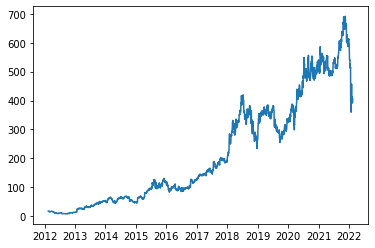

In [3]:
#데이터 확인 시각화
plt.plot(nflx)

### 각종 전처리 수행

In [4]:
# 결측치 처리
nflx = nflx.interpolate(method='time')
nflx[nflx.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

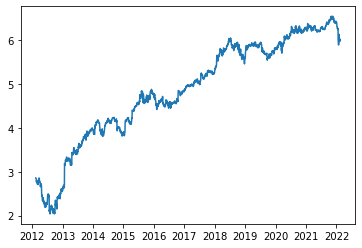

In [5]:
# 로그 변환 시도 
nflx_log = np.log(nflx)
plt.plot(nflx_log)

### 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

#### 정성적 그래프 분석

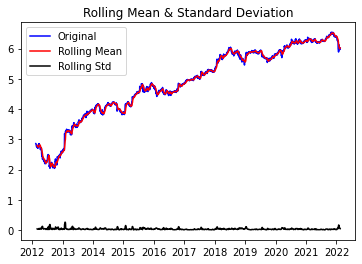

In [6]:
# 정성적 그래프 분석

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(nflx_log, window=12)

#### 정량적 Augmented Dicky-Fuller Test

시계열 데이터 안정적인 기준
* 검정 통계량(ADF statistic)이 Critical value보다 작으면 stationary한 시계열 데이터
* P-value가 설정한 신뢰수준 값인 0.05보다 작으면 stationary한 시계열 데이터

In [7]:
# 정량적 Augmented Dicky-Fuller Test
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [8]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(nflx_log)

Results of Dickey-Fuller Test:
Test Statistic                   -1.493569
p-value                           0.536690
#Lags Used                        5.000000
Number of Observations Used    2511.000000
Critical Value (1%)              -3.432957
Critical Value (5%)              -2.862692
Critical Value (10%)             -2.567383
dtype: float64


stationary하지 않은 데이터로 보임

#### 시계열 분해

안정적이지 않은 시계열을 분석하려면 안정적인 시계열로 바꾸어야 한다.
그 기법으로 시계열 분해를 시도해보겠다.

시계열 분해는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있는데 이를 활용하면 moving average 제거, differencing 등을 거치지 않고도 훨씬 안정적인 시계열을 분리할 수 있다.

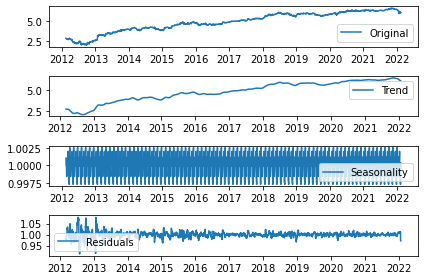

In [9]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(nflx_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(nflx_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### Residual 안정성 확인

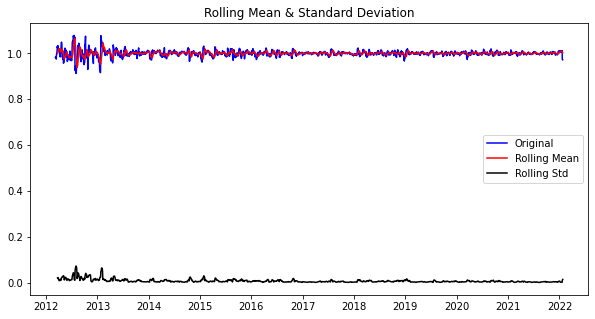

In [10]:
plt.rcParams["figure.figsize"] = (10,5)
plot_rolling_statistics(residual)

In [11]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.555006e+01
p-value                        2.105612e-28
#Lags Used                     1.800000e+01
Number of Observations Used    2.468000e+03
Critical Value (1%)           -3.433002e+00
Critical Value (5%)           -2.862712e+00
Critical Value (10%)          -2.567394e+00
dtype: float64


### 학습, 테스트 데이터셋 생성

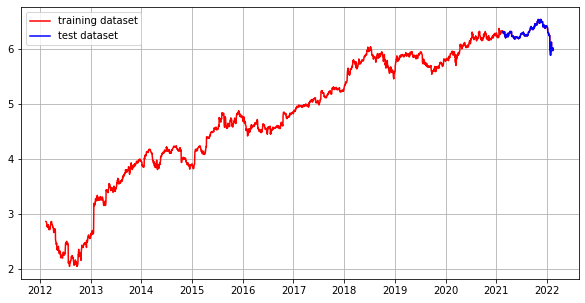

In [12]:
train_data, test_data = nflx_log[:int(len(nflx_log)*0.9)], nflx_log[int(len(nflx_log)*0.9):]
plt.figure(figsize=(10,5))
plt.grid(True)
plt.plot(nflx_log, c='r', label='training dataset') 
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


### 적정 ARIMA 모수 찾기

ARIMA(p,d,q)

AR : 자기 회귀 모형(Autoregressive), 과거 값들에 대한 회귀로 미래 값을 예측, 시계열의 residual에 해당하는 부분을 모델링

I : 차분 누적(integration), 시계열의 seasonality에 해당하는 부분을 모델링 

MA : 이동평균 모형(Moving Average), 과거의 잘 알 수 없는 원인이 겹쳐서 현재의 데이터가 생겨남, 시계열의 trend에 해당하는 부분을 모델링



p = AR모형의 lag, d = 차분의 횟수, q = MA모형의 lag

- ACF, PACF 그래프를 통해 p,q 구하기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


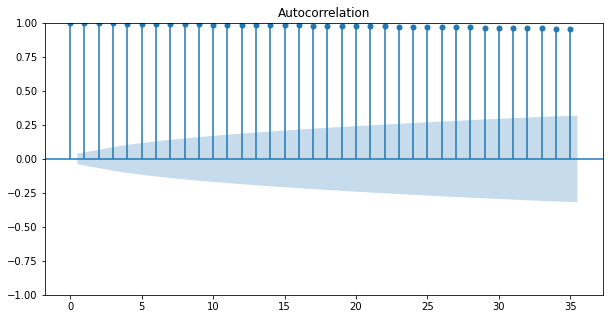

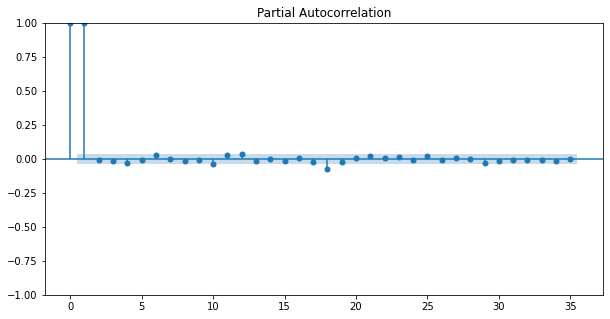

In [13]:
# ACF, PACF 그려보기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(nflx_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(nflx_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


ACF는 시차가 진행 됨에 따라 점차 감소하고 있는 형태를 보이고 PACF는 시차가 진행 됨에 따라 2부터 0에 급격하게 가까워지는 모습을 보이고 있다. 따라서 p는 1로 진행 (이들 중 p 와 q 는 일반적으로 p + q < 2, p * q = 0 인 값을 사용)

- 차분(d) 구하기

Results of Dickey-Fuller Test:
Test Statistic                  -23.317548
p-value                           0.000000
#Lags Used                        4.000000
Number of Observations Used    2511.000000
Critical Value (1%)              -3.432957
Critical Value (5%)              -2.862692
Critical Value (10%)             -2.567383
dtype: float64


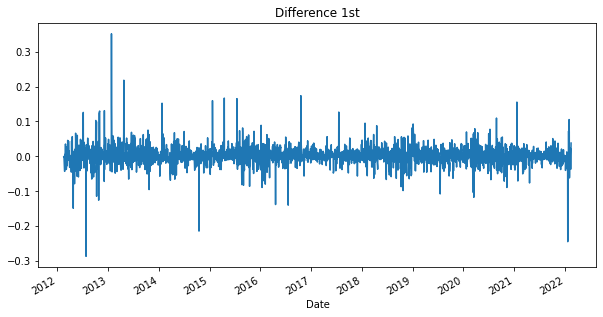

In [14]:
# 1차 차분 구하기
diff_1 = nflx_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
#diff_2 = diff_1.diff(periods=1).iloc[1:]
#diff_2.plot(title='Difference 2nd')

#augmented_dickey_fuller_test(diff_2)

1차 차분만 해줘도 안정적이라고 판단이 되어 1차만 실행했다. 따라서 arima 파라미터 d의 값은 1로 설정

### ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련

In [15]:
# Build Model
model = ARIMA(train_data, order=(1,1,0))  #pdq
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2265
Model:                 ARIMA(1, 1, 0)   Log Likelihood                4739.993
Date:                Wed, 16 Feb 2022   AIC                          -9475.987
Time:                        17:13:43   BIC                          -9464.537
Sample:                             0   HQIC                         -9471.809
                               - 2265                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0290      0.013      2.223      0.026       0.003       0.054
sigma2         0.0009   8.64e-06    102.859      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.02   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


- 모델 테스트 및 플로팅

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


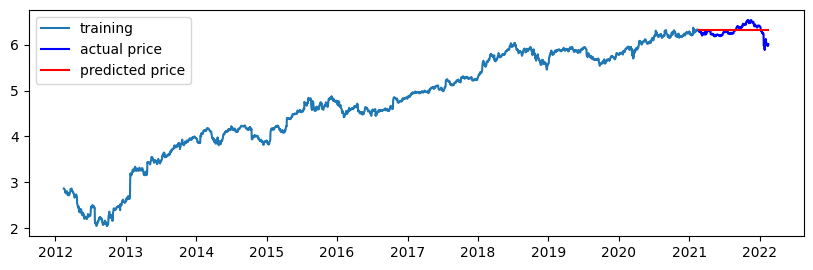

In [16]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,3), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

- 최종 예측 모델 정확도 측정(MAPE)

In [17]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4700.568324181657
MAE:  55.695672108959
RMSE:  68.560690808813
MAPE: 10.56%


실제 값과 예측 값을 비교해 본 결과, 예측이 잘 되었다 !

## SK 하이닉스

5년치 데이터로 진행 (2017.02.16-2022.02.15)

### 데이터 준비

In [18]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/000660.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
sk = df['Close']

sk

Date
2017-02-16     49600.0
2017-02-17     50400.0
2017-02-20     49900.0
2017-02-21     50900.0
2017-02-22     50600.0
                ...   
2022-02-09    123000.0
2022-02-10    129500.0
2022-02-11    132000.0
2022-02-14    132500.0
2022-02-15    127000.0
Name: Close, Length: 1224, dtype: float64

### 데이터 확인

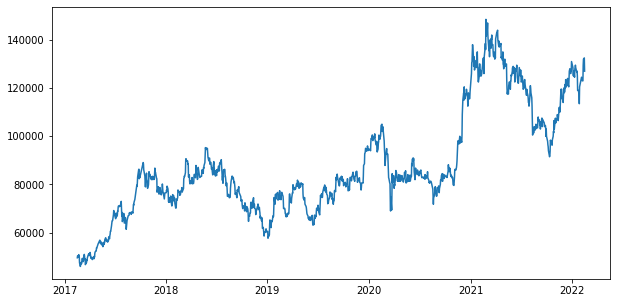

In [19]:
#데이터 확인 시각화
plt.plot(sk)

### 각종 전처리 수행

In [20]:
# 결측치 처리
sk = sk.interpolate(method='time')
sk[sk.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

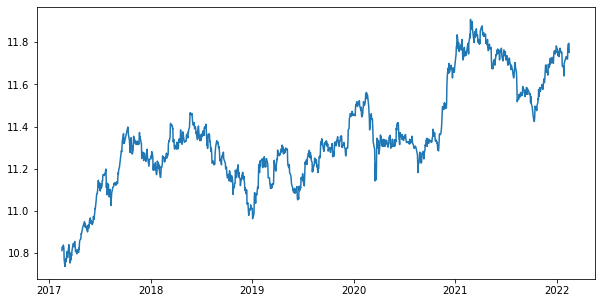

In [21]:
# 로그 변환 시도 
sk_log = np.log(sk)
plt.plot(sk_log)

### 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

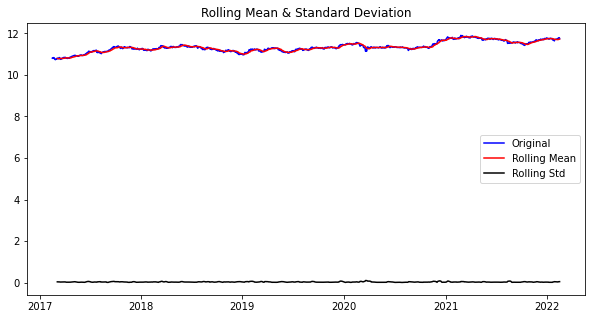

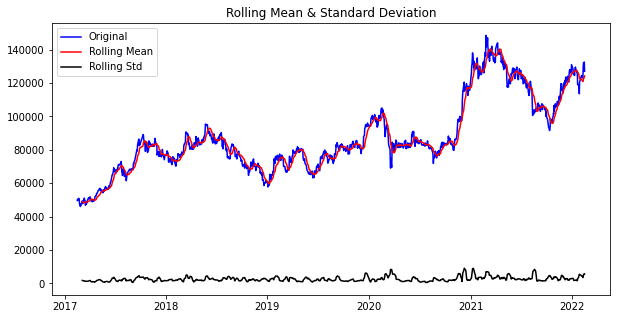

In [22]:
# 정성적 그래프 분석

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(sk_log, window=12)
plot_rolling_statistics(sk, window =12)

In [23]:
# 정량적 Augmented Dicky-Fuller Test
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [24]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(sk_log)

Results of Dickey-Fuller Test:
Test Statistic                   -1.856030
p-value                           0.353020
#Lags Used                        1.000000
Number of Observations Used    1222.000000
Critical Value (1%)              -3.435713
Critical Value (5%)              -2.863908
Critical Value (10%)             -2.568031
dtype: float64


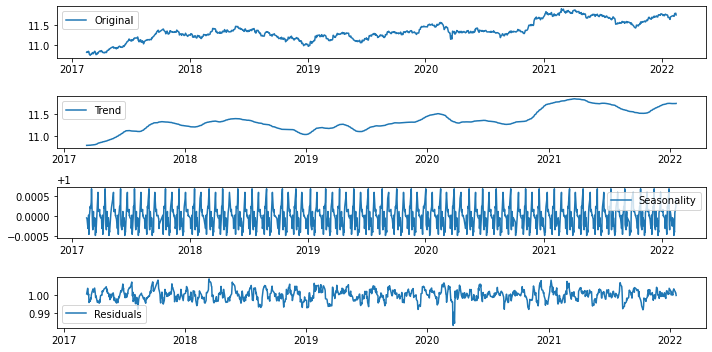

In [25]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(sk_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(sk_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

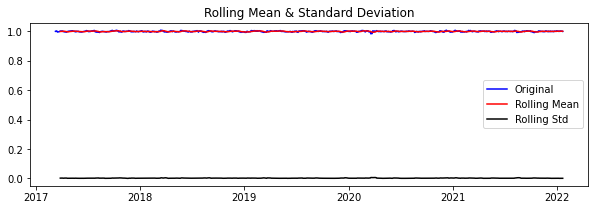

In [26]:
#Residual 안정성 확인

plt.rcParams["figure.figsize"] = (10,3)
plot_rolling_statistics(residual)

In [27]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.067141e+01
p-value                        4.157944e-19
#Lags Used                     2.200000e+01
Number of Observations Used    1.171000e+03
Critical Value (1%)           -3.435947e+00
Critical Value (5%)           -2.864011e+00
Critical Value (10%)          -2.568086e+00
dtype: float64


### 학습, 테스트 데이터셋 생성

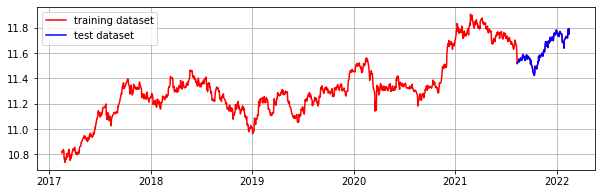

In [28]:
train_data, test_data = sk_log[:int(len(sk_log)*0.9)], sk_log[int(len(sk_log)*0.9):]
plt.figure(figsize=(10,3))
plt.grid(True)
plt.plot(sk_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 적정 ARIMA 모수 찾기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


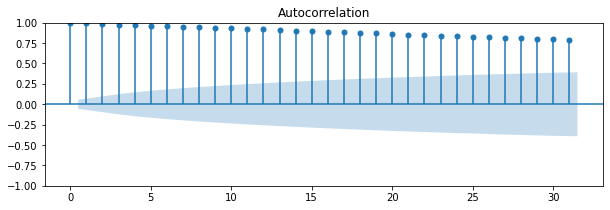

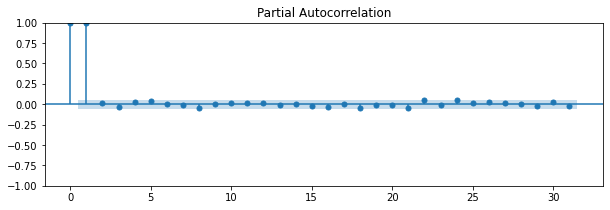

In [29]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(sk_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(sk_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -36.664379
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1222.000000
Critical Value (1%)              -3.435713
Critical Value (5%)              -2.863908
Critical Value (10%)             -2.568031
dtype: float64


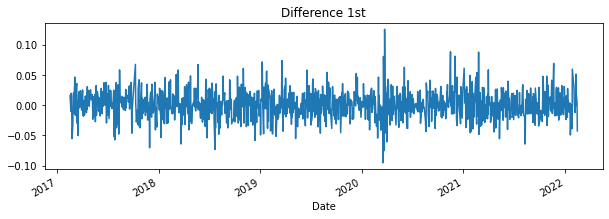

In [30]:
# 1차 차분 구하기
diff_1 = sk_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
#diff_2 = diff_1.diff(periods=1).iloc[1:]
#diff_2.plot(title='Difference 2nd')

#augmented_dickey_fuller_test(diff_2)

### ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련

In [31]:
# Build Model
model = ARIMA(train_data, order=(1,1,0))  #pdq
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1101
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2578.383
Date:                Wed, 16 Feb 2022   AIC                          -5152.766
Time:                        17:13:46   BIC                          -5142.760
Sample:                             0   HQIC                         -5148.981
                               - 1101                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0483      0.023     -2.117      0.034      -0.093      -0.004
sigma2         0.0005   1.73e-05     31.145      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


- 모델 테스트 및 플로팅

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


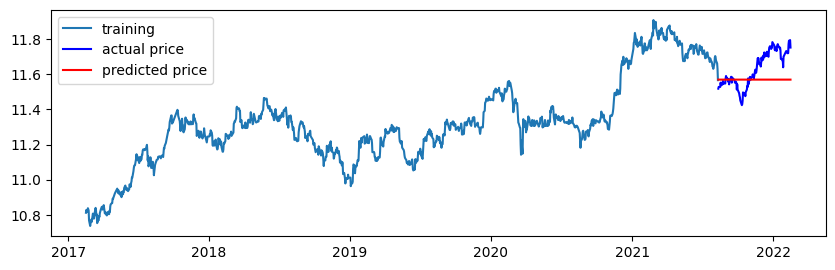

In [32]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,3), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

- 최종 예측 모델 정확도 측정(MAPE)

In [33]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  165995800.10340494
MAE:  10194.14703968594
RMSE:  12883.935738096683
MAPE: 8.61%


실제 값과 예측 값을 비교해 본 결과, 예측이 잘 된지 모르겠다 !

## 대한항공

5년치 데이터로 진행 (2017.02.15 - 2022.02.14)

### 데이터 준비

In [34]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/003490.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
kair = df['Close']

kair

Date
2017-02-15    27300.0
2017-02-16    26550.0
2017-02-17    26400.0
2017-02-20    26750.0
2017-02-21    27850.0
               ...   
2022-02-08    29800.0
2022-02-09    29800.0
2022-02-10    30250.0
2022-02-11    30150.0
2022-02-14    29900.0
Name: Close, Length: 1224, dtype: float64

In [35]:
len(kair)

1224

### 데이터 확인

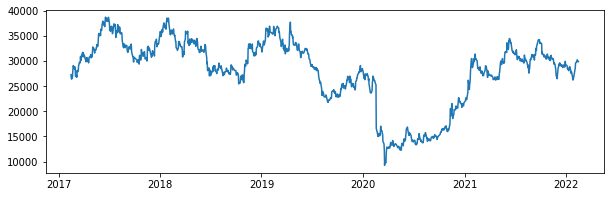

In [36]:
#데이터 확인 시각화
plt.plot(kair)

### 각종 전처리 수행

In [37]:
# 결측치 처리
kair = kair.interpolate(method='time')
kair[kair.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

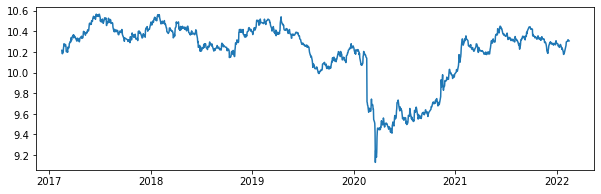

In [38]:
# 로그 변환 시도 
kair_log = np.log(kair)
plt.plot(kair_log)

### 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

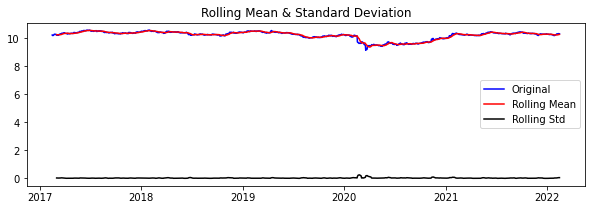

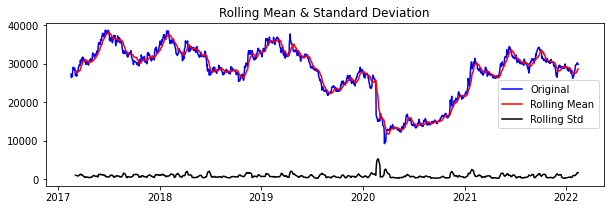

In [39]:
# 정성적 그래프 분석

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
plot_rolling_statistics(kair_log, window=12)
plot_rolling_statistics(kair, window =12)

In [40]:
# 정량적 Augmented Dicky-Fuller Test
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [41]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(kair_log)

Results of Dickey-Fuller Test:
Test Statistic                   -2.029670
p-value                           0.273717
#Lags Used                       23.000000
Number of Observations Used    1200.000000
Critical Value (1%)              -3.435811
Critical Value (5%)              -2.863952
Critical Value (10%)             -2.568054
dtype: float64


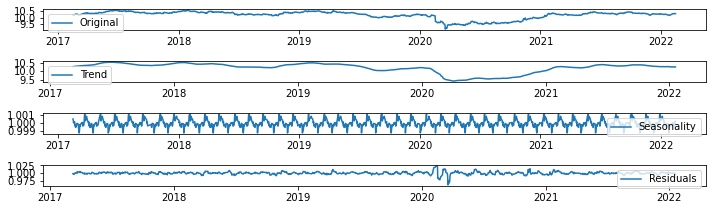

In [42]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(kair_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(kair_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

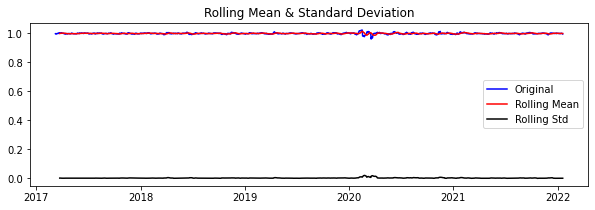

In [43]:
#Residual 안정성 확인

plt.rcParams["figure.figsize"] = (10,3)
plot_rolling_statistics(residual)

In [44]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.056159e+01
p-value                        7.703165e-19
#Lags Used                     2.200000e+01
Number of Observations Used    1.171000e+03
Critical Value (1%)           -3.435947e+00
Critical Value (5%)           -2.864011e+00
Critical Value (10%)          -2.568086e+00
dtype: float64


### 학습, 테스트 데이터셋 생성

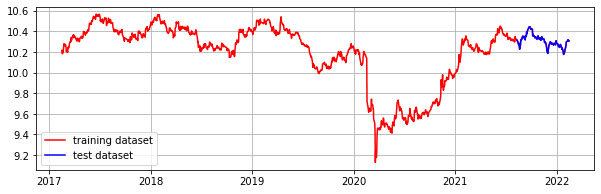

In [45]:
train_data, test_data = kair_log[:int(len(kair_log)*0.9)], kair_log[int(len(kair_log)*0.9):]
plt.figure(figsize=(10,3))
plt.grid(True)
plt.plot(kair_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### 적정 ARIMA 모수 찾기

ARIMA의 모수는 크게 3가지가 있다. AR모형의 Lag을 의미하는 p, MA모형의 Lag을 의미하는 q, 차분(Diffrence)횟수를 의미하는 d 가 그것이다. 보통은 p, d, q의 순서로 쓴다

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


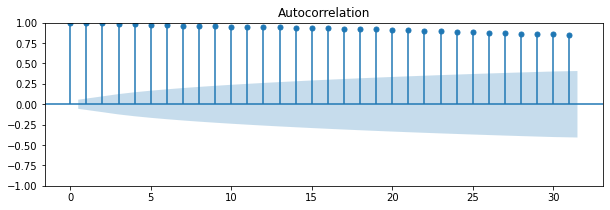

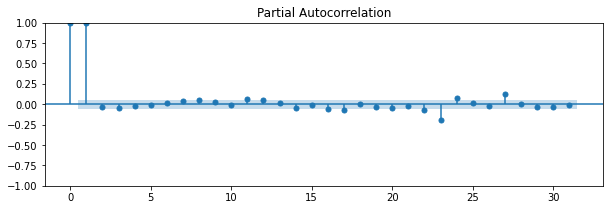

In [46]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(kair_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(kair_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -5.867610e+00
p-value                        3.297216e-07
#Lags Used                     2.200000e+01
Number of Observations Used    1.200000e+03
Critical Value (1%)           -3.435811e+00
Critical Value (5%)           -2.863952e+00
Critical Value (10%)          -2.568054e+00
dtype: float64


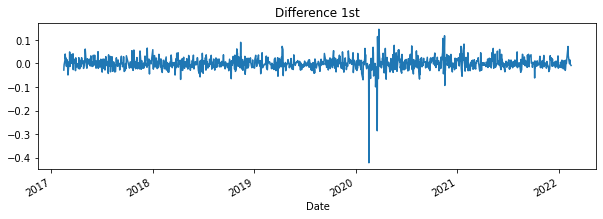

In [47]:
# 1차 차분 구하기
diff_1 = kair_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# # 혹시 필요한 경우 2차 차분 구하기
# diff_2 = diff_1.diff(periods=1).iloc[1:]
# diff_2.plot(title='Difference 2nd')

# augmented_dickey_fuller_test(diff_2)

### ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련

In [48]:
# Build Model
model = ARIMA(train_data, order=(1,1,0))  #pdq
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1101
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2371.821
Date:                Wed, 16 Feb 2022   AIC                          -4739.641
Time:                        17:13:49   BIC                          -4729.635
Sample:                             0   HQIC                         -4735.856
                               - 1101                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0235      0.016      1.457      0.145      -0.008       0.055
sigma2         0.0008   6.42e-06    122.252      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.00   Jarque-

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


- 모델 테스트 및 플로팅

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


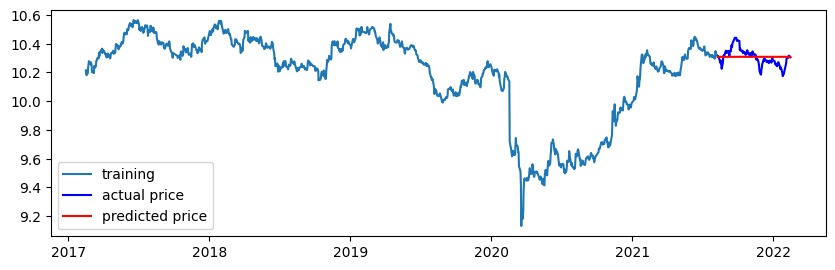

In [49]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,3), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

실제 값과 예측 값을 비교해 본 결과, 예측이 잘 되었다 !

- 최종 예측 모델 정확도 측정(MAPE)

In [50]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2955882.098157105
MAE:  1336.717874241103
RMSE:  1719.2678959827945
MAPE: 4.49%


## 추가적으로 궁금한 점 분석

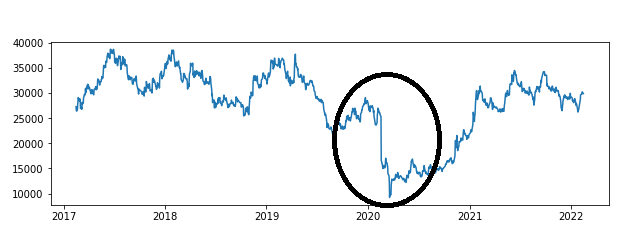

In [72]:
Image("kair_image.png")

대한항공 그래프를 보던 중 위의 그림과 같이 급하락 하는 구간을 볼 수 있다. 그래서 과연 이 시기에 어떤 일이 있었는지 궁금해져서 한 번 알아보고 싶어졌다

- 2020년 상반기 데이터 새로 가져오기

In [53]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/003490.KS (1).csv'

df1=pd.read_csv(dataset_filepath)
df1

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,28500.000000,28550.000000,27750.000000,27850.000000,27850.000000,303459
1,2020-01-03,28000.000000,28150.000000,27250.000000,27300.000000,27300.000000,572272
2,2020-01-06,26850.000000,27100.000000,26000.000000,26500.000000,26500.000000,690224
3,2020-01-07,26500.000000,27150.000000,26400.000000,26850.000000,26850.000000,388103
4,2020-01-08,26450.000000,26700.000000,25950.000000,26300.000000,26300.000000,676198
...,...,...,...,...,...,...,...
77,2020-04-23,13503.809570,13673.455078,13232.375977,13402.021484,13402.021484,2651562
78,2020-04-24,13639.525391,13741.313477,13266.304688,13435.951172,13435.951172,3572234
79,2020-04-27,14080.605469,14182.392578,13435.951172,13503.809570,13503.809570,3654424
80,2020-04-28,13537.738281,13571.667969,13266.304688,13368.092773,13368.092773,1743605


In [54]:
#주식 최저값 찾아보기
df1['Low'].min()

8685.867188

In [55]:
#주식 최저값 인덱스 찾기
reqd_index = df1.query('Low == 8685.867188').index.tolist()
print(reqd_index)

[54]


In [56]:
#대한항공 주식 최저 찍은 날 찾기
print(type(df1.loc[[54]]))
df1.loc[[54]]

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
54,2020-03-20,9228.734375,11094.837891,8685.867188,10348.396484,10348.396484,11468349


In [57]:
#대한항공 주식 High 최저 찾기
df1['High'].min()

10314.467773

In [58]:
# high 인덱스 찾기
high_index = df1.query('High == 10314.467773').index.tolist()
print(high_index)

[56]


In [59]:
#대한항공 주식 high 최저 찍은 날 찾기
print(type(df1.loc[[56]]))
df1.loc[[56]]

<class 'pandas.core.frame.DataFrame'>


,Date,Open,High,Low,Close,Adj Close,Volume
56,2020-03-24,9941.246094,10314.467773,9839.458984,10178.750977,10178.750977,3949440


### 2020년 3월 12일 기사 (3월 20일 이전부터 그래프가 하강하고 있어서 20일 전 기사 찾아보기)

http://www.jejusori.net/news/articleView.html?idxno=313134

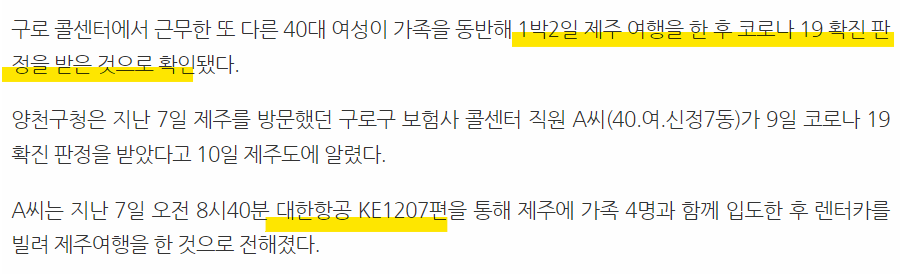

### 2020년 3월 20일 기사 (최저점 찍은 날 기사 찾아보기)

https://www.dailian.co.kr/news/view/877349?sc=Naver

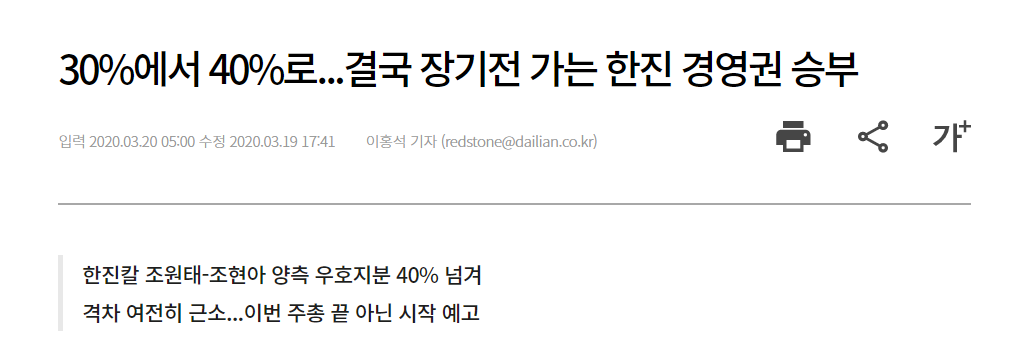

http://www.newsway.co.kr/news/view?tp=1&ud=2020031915103246289

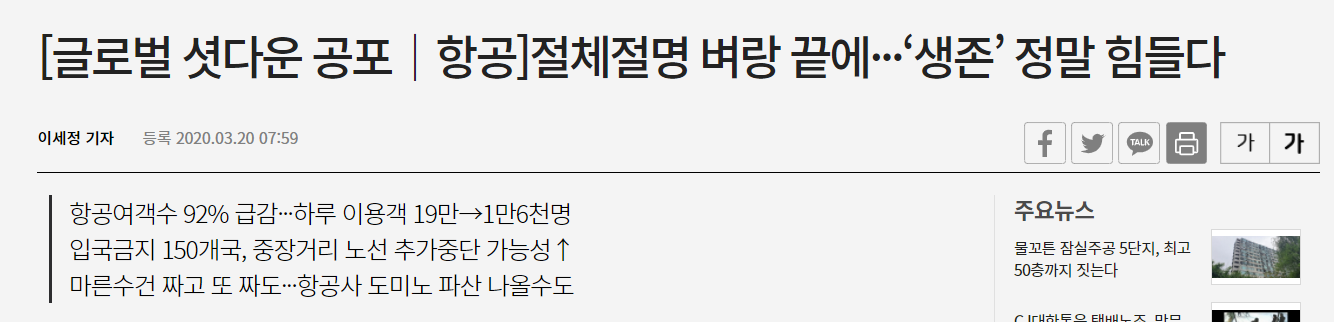


3월 24일 기사도 코로나와 경영권 내용이 주된 기사 내용이었다. 기사에도 나와 있듯이 코로나 사태로 전세계가 셧다운이 되면서 관광산업과 항공계가 많이 어려워 대한항공도 같이 큰 타격을 받은 듯하다. 이와 맞물려 경영권 분쟁도 있어서 이 시기에 대한항공 주가가 많이 하락한 것으로 보인다.

## Retrospection

- 이번 exploration은 노드를 공부할 때는 너무 어려웠는데 프로젝트를 진행하면서 나름 재미가 있었다.
원래 왜 주가가 높았고 낮았는지 분석한 후에 다음날 혹은 일주일 후의 주가까지 예측을 해보고 싶었다. 분명 다 이해하고 적용할 수 있을 거라고 생각했는데 막상 코드로 구현을 하려고 하니까 어떤 방식으로 구현을 해야 하는지 감이 안온다...이 점이 아쉽지만 아쉬운 대로 왜 낮은지에 대해서만 알아보았다. 미래 주가 예측을 하지 못한 것으로 보아 나는 'arima 모델 훈련과 추론' 부분에 대한 이해가 부족하고 파이썬에 대한 이해가 부족한 것 같다. 흑흑


- pdq 파라미터 조정하는 것도 이해가 어려워서 힘들었고 airma 그래프도 아직은 어렵지만 프로젝트를 진행하면서 전반적으로 이해가 되었다.


- ACF, PACF 그래프를 그리는 과정인 <plot_acf(kair_log)> 이 코드에 log가 아닌 Residual을 한 과정을 넣어야 되는 것이 아닌지에 대한 질문이 있었다. 생각을 해보니 log를 취한 그래프는 안정적이지 않은 그래프이고 log그래프를 안정적으로 만들어주기 위해서 residual을 한 것인데 arima그래프에 log를 넣는 것이 이상하다는 생각이 들었다. 그래서 찾아 본 결과, arima에 시계열을 안정적으로 해주는 기능이 있다는 것을 알게 되었다. 왜 log가 들어가는지에 대해 궁금증을 가진 적이 없었다. 어찌 보면 당연한 것인데 arima에 그런 기능이 있기 때문에 시계열 분해를 하기 전 그래프인 log가 들어가는 것이 맞는 것이다.


- netflix, sk하이닉스, 대한항공을 예측해 보았는데 예측을 시각화 한 것을 보았을 때 netflix와 대한항공은 주가예측이 잘 되었다. sk하이닉스는 시각화 결과로만 보았을 때는 주가예측이 잘 되었다고 할 수는 없는 것 같다. 그러나 mape값이 netflix 10.56%, sk하이닉스 8.61%, 대한항공 4.49%인 것을 보았을 때, netflix의 mape값보다 sk하이닉스의 mape값이 더 낮은게 의아하다. 